In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №10: Градиентный бустинг</b></h3>

<p lang="ru" style="hyphens: auto; text-align: justify">Градиентный бустинг — это техника построения ансамблей, в которой предсказатели построены последовательно. Это техника использует идею о том, что следующая модель будет учиться на ошибках предыдущей. Они имеют неравную вероятность появления в последующих моделях, и чаще появляются те, что дают наибольшую вероятность ошибки. Предсказатели могут быть выбраны из широкого ассортимента моделей, например, деревья решений, регрессия, классификаторы и прочее. Из-за того, что предсказатели обучаются на ошибках, совершенных предыдущими, требуется меньше времени для того, чтобы добраться до реального ответа.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np

In [5]:
# Импортирование функции для загрузки данных.
from sklearn.datasets import load_boston

In [6]:
# Импортирование функции для разделения исходной выборки данных.
from sklearn.model_selection import train_test_split

In [7]:
# Импортирование алгоритма градиентного бустинга.
from sklearn.ensemble import GradientBoostingRegressor

In [8]:
# Импортирование алгоритма дерева решений.
from sklearn.tree import DecisionTreeRegressor

In [9]:
# Импортирование алгоритма линейной регрессии.
from sklearn.linear_model import LinearRegression

In [10]:
# Импортирование функция вычисления стоимости модели.
from sklearn.metrics import mean_squared_error

In [11]:
# Импортирование функции индикатора выполнения.
from tqdm import tqdm_notebook

In [12]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [13]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>boston_house_prices.csv</tt> при помощи внешней библиотеки sklearn. Текущий набор данных содержит некоторую информацию о ценах на жилье, включая прогнозирование цены дома в тысячах долларов с учетом подробностей о доме и его окрестностях.</p>

In [14]:
data = load_boston()

In [15]:
data_x = np.array(data.data)
data_y = np.array(data.target)

In [16]:
# Создание тренировочной и контрольной выборки данных.
x_train, x_tests, y_train, y_tests = train_test_split(data_x, data_y)

<p lang="ru"><b>Пункт №2:&nbsp;</b>Реализация функции вычисления значения среднеквадратичного отклонения. Среднеквадратичное отклонение является часто используемой мерой различий между значениями, прогнозируемыми моделью или оценщиком, и наблюдаемыми значениями. Среднеквадратичное отклонение представляет собой квадратный корень из второго момента выборки различий между предсказанными значениями и наблюдаемыми значениями или среднеквадратичное значение этих различий. Эти отклонения называются остаточными значениями, когда вычисления выполняются для выборки данных, которая использовалась для оценки, и называются ошибками прогнозирования при расчете вне выборки.</p>

In [17]:
def calc_rmse(y, y_pred):
    # Вычисление значения среднеквадратичного отклонения.
    return np.sqrt(mean_squared_error(y, y_pred))

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции оптимизации математической модели градиентого бустинга. Данный метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент стоимости модели по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента стоимости модели.</p>

In [18]:
def calc_pred(x, regressors):
    # Функция вычисления прогнозов построенной композиции деревьев на выборке данных.
    return [np.sum([gamma * regressor.predict([xi])[0] for gamma, regressor in regressors])
                                                       for xi in x]

In [19]:
def calc_boost(x, y, n_estimators=50):
    # Инициализация результирующей модели.
    regressors = []

    # Инициализация начальных псевдо-остатков модели.
    y_hat = np.full(y.shape[0], y.mean())
    for i in tqdm_notebook(range(n_estimators)):
        # Обучение некоторой слабой модели.
        regressor = DecisionTreeRegressor(max_depth=5, random_state=42).fit(x, y_hat)

        # Вычисление гаммы рассматриваемого шага.
        gamma = 0.9

        # Добавление полученной модели в ансамбль.
        regressors.append((gamma, regressor))

        # Вычисление псевдо-остатков модели.
        y_hat = y - calc_pred(x, regressors)

    return regressors

In [20]:
%%time

# Запуск оптимизации математической модели.
ensemble = calc_boost(x_train, y_train)


CPU times: user 32.5 s, sys: 144 ms, total: 32.6 s
Wall time: 32.9 s


In [21]:
# Вычисление значения стоимости обученного ансамбля математических моделей.
print('Значение стоимости:', calc_rmse(y_tests, calc_pred(x_tests, ensemble)))

Значение стоимости: 5.2041330999774384


<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация функции оптимизации математической модели градиентого бустинга с адаптивной скоростью обучения. Адаптация скорости обучения подразумевает собой процедуру плавного уменьшения некоторого начального значения скорости обучения в процессе оптимизации. Данное действие необходимо для уменьшения вероятности перескакивания через минимум заданной функции.</p>

In [22]:
def calc_boost(x, y, n_estimators=50):
    # Инициализация результирующей модели.
    regressors = []

    # Инициализация начальных псевдо-остатков модели.
    y_hat = np.full(y.shape[0], y.mean())
    for i in tqdm_notebook(range(n_estimators)):
        # Обучение некоторой слабой модели.
        regressor = DecisionTreeRegressor(max_depth=5, random_state=42).fit(x, y_hat)

        # Вычисление гаммы рассматриваемого шага.
        gamma = 0.9 / (1.0 + i % 10)

        # Добавление полученной модели в ансамбль.
        regressors.append((gamma, regressor))

        # Вычисление псевдо-остатков модели.
        y_hat = y - calc_pred(x, regressors)

    return regressors

In [23]:
%%time

# Запуск оптимизации математической модели.
ensemble = calc_boost(x_train, y_train)


CPU times: user 33.2 s, sys: 181 ms, total: 33.4 s
Wall time: 33.6 s


In [24]:
# Вычисление значения стоимости обученного ансамбля математических моделей.
print('Значение стоимости:', calc_rmse(y_tests, calc_pred(x_tests, ensemble)))

Значение стоимости: 4.241887970107671


<p lang="ru"><b>Пункт №5:&nbsp;</b>Построение и сравнение нескольких математических моделей градиентного бустинга с разными значениями гиперпараметров. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных и сравнению влияний разнообразных значений гиперпараметра на обобщающую способность. После проведения сравнений можно заметить, что с увеличением числа деревьев, начиная с некоторого момента, алгоритм начинает сильно переобучаться и качество его работы на тестируемой выборке начинает ухудшаться.</p>

In [25]:
# Генерация разных значений размеров модели.
tree_counts = range(5, 90, 10)

# Генерация разных значений глубины модели.
tree_depths = range(1, 18, 2)

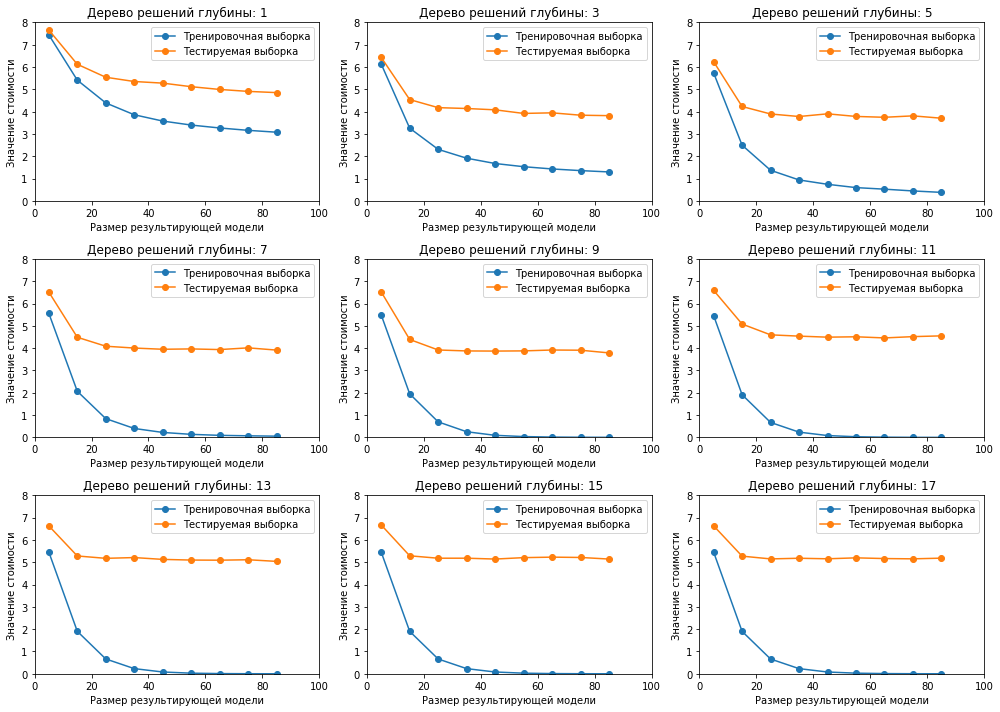

In [26]:
# Создание совместного полотна для графиков.
figure = pyplot.figure(figsize=(14, 10))

for num, depth in enumerate(tree_depths):
    # Создание контейнеров для накопления стоимостей.
    train_cost = []
    tests_cost = []

    for count in tree_counts:
        # Создание математической модели с рассматриваемыми гиперпараметрами.
        regressor = GradientBoostingRegressor(n_estimators=count, max_depth=depth)

        # Запуск оптимизации математической модели.
        regressor.fit(x_train, y_train)

        # Вычисление и сохранение стоимостей на тренировочной и тестируемой выборке.
        train_cost.append(calc_rmse(y_train, regressor.predict(x_train)))
        tests_cost.append(calc_rmse(y_tests, regressor.predict(x_tests)))

    # Создание текущего полотна для графика.
    ax = figure.add_subplot(3, 3, num+1)

    # Построение процесса обучения математической модели.
    ax.plot(tree_counts, train_cost, label='Тренировочная выборка', marker='o')
    ax.plot(tree_counts, tests_cost, label='Тестируемая выборка', marker='o')

    # Настройка заглавия графика.
    ax.set_title('Дерево решений глубины: {}'.format(depth))

    # Настройка координатных осей графика.
    ax.set_xlabel('Размер результирующей модели')
    ax.set_ylabel('Значение стоимости')

    # Построение легенды графика.
    ax.legend(loc='best')

    # Масштабирование для сравнения.
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 8)

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №6:&nbsp;</b>Сравнение значений среднеквадратичного отклонения, получаемого с помощью градиентного бустинга и линейной регрессии. После сравнения полученных результатов можно сделать вывод, что градиентый бустинг превосходит линейную регрессию и на практике очень часто является самым эффективным алгоритмом.</p>

In [27]:
%%time

# Запуск оптимизации математической модели.
model = LinearRegression().fit(x_train, y_train)

CPU times: user 1.5 ms, sys: 287 µs, total: 1.79 ms
Wall time: 2.09 ms


In [28]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_rmse(y_tests, model.predict(x_tests)))

Значение стоимости: 5.457311159564068
